In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [2]:
import importlib
import sys
sys.path.append('../')
from Utils.perturbationsnew import RBPIndividual, RBPIndividualNew1, RBPIndividualNew2, zeroPerturb, noisePerturb, blurPerturb
from Utils.models import *
from Utils.data import perturb, generateSynthetic, generateSyntheticPerturbReal,ReadTS

print(sys.path)


['/Users/gali/anaconda3/envs/LIMEtf/lib/python310.zip', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/lib-dynload', '', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/site-packages', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/site-packages/setuptools/_vendor', '../', '../']


In [3]:
from IPython.display import display, HTML

# 设置默认输出折叠
display(HTML('''
<style>
.output {
    display: flex;
    flex-direction: column;
}
.output_scroll {
    max-height: 300px; 
    overflow-y: auto;
}
</style>
'''))

## Test important content removal (accuracy decrease)

### Load synthetic dataset and train CNN model 

In [4]:
x_test_original, y_test_original,x_train, y_train = ReadTS('ChlorineConcentration')
y_train = y_train - 1
y_test_original = y_test_original - 1
print(x_train.shape)
#print(y_train)

(3840, 166, 1)


In [5]:
from sklearn.preprocessing import StandardScaler
def normalize(TS):
    # 获取原始数据集的形状
    original_shape = TS.shape
    
    # 将数据集reshape成二维数组
    TS_2d = TS.reshape(original_shape[0] , original_shape[1])
    
    # 初始化StandardScaler
    scaler = StandardScaler()
    
    # 对数据集进行标准化
    TS_normalized = scaler.fit_transform(TS_2d)
    
    # 将标准化后的数据集reshape回原始形状
    TS = TS_normalized.reshape(original_shape)
    
    return TS

x_train = normalize(x_train)
x_test_original = normalize(x_test_original)
#print(x_train)

In [6]:
model = make_CNN_model(x_train.shape[1:],num_classes = 3)
trained_model, history = train_CNN_model(model, x_train, y_train, epochs=150, batch_size=32)

Epoch 1/150


2024-11-27 21:32:01.155016: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


96/96 [==============================] - 1s 9ms/step - loss: 0.9825 - sparse_categorical_accuracy: 0.5583 - val_loss: 1.0593 - val_sparse_categorical_accuracy: 0.5378
Epoch 2/150
96/96 [==============================] - 1s 9ms/step - loss: 0.9609 - sparse_categorical_accuracy: 0.5687 - val_loss: 1.1402 - val_sparse_categorical_accuracy: 0.5169
Epoch 3/150
96/96 [==============================] - 1s 9ms/step - loss: 0.9561 - sparse_categorical_accuracy: 0.5732 - val_loss: 1.1657 - val_sparse_categorical_accuracy: 0.5417
Epoch 4/150
96/96 [==============================] - 1s 10ms/step - loss: 0.9521 - sparse_categorical_accuracy: 0.5739 - val_loss: 1.0197 - val_sparse_categorical_accuracy: 0.5690
Epoch 5/150
96/96 [==============================] - 1s 11ms/step - loss: 0.9503 - sparse_categorical_accuracy: 0.5687 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 0.5768
Epoch 6/150
96/96 [==============================] - 1s 11ms/step - loss: 0.9415 - sparse_categorical_accuracy: 0.5

In [7]:
test_loss, test_acc = trained_model.evaluate(x_test_original, y_test_original)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

15/15 [==============================] - 0s 3ms/step - loss: 0.4615 - sparse_categorical_accuracy: 0.8180
Test accuracy 0.8179871439933777
Test loss 0.4614582657814026


### Create perturbed test sets and calculate decrease in accuracy

In [8]:
print(y_test_original.shape)

(467,)


In [24]:
predictions_original = model.predict(x_test_original)
perturb_test_set = x_test_original.copy()
perturb_test_set = perturb_test_set.reshape(x_test_original.shape[0:2])
index_0 = 66
index_1 = 160

x_test_rbp = np.asarray([perturb('RBP',x,index_0,index_1) for x in perturb_test_set])
x_test_rbp = np.expand_dims(x_test_rbp, axis=-1)
predictions_rbp = model.predict(x_test_rbp)

pert1 = perturb('RBP1',perturb_test_set[0],index_0,index_1, global_ts = perturb_test_set)
x_test_new1 = np.asarray([perturb('RBP1',x,index_0,index_1, global_ts = perturb_test_set) for x in perturb_test_set])
x_test_new1 = np.expand_dims(x_test_new1, axis=-1)
predictions_new1 = model.predict(x_test_new1)

#x_test_new2 = np.asarray([perturb('RBP2',x,400,500, global_ts = perturb_test_set) for x in perturb_test_set])
#x_test_new2 = np.expand_dims(x_test_new2, axis=-1)
#predictions_new2 = model.predict(x_test_new2)

x_test_zero = np.asarray([perturb('zero',x,index_0,index_1) for x in perturb_test_set])
x_test_zero = np.expand_dims(x_test_zero, axis=-1)
predictions_zero = model.predict(x_test_zero)

x_test_noise = np.asarray([perturb('noise',x,index_0,index_1) for x in perturb_test_set])
x_test_noise = np.expand_dims(x_test_noise, axis=-1)
predictions_noise = model.predict(x_test_noise)

x_test_blur = np.asarray([perturb('blur',x,index_0,index_1) for x in perturb_test_set])
x_test_blur = np.expand_dims(x_test_blur, axis=-1)
predictions_blur = model.predict(x_test_blur)

15/15 [==============================] - 0s 3ms/step


In [25]:
def accuracy(predictions, labels):
    hits = 0
    for i in range(0,len(predictions)):
        if predictions[i] == labels[i]:
            hits += 1
    return hits/len(predictions)

def AveragSuccessRate(predictions, labels):
    hits = 0
    for i in range(0,len(predictions)):
        if predictions[i] != labels[i]:
            hits += 1
    return hits/len(predictions)

In [26]:
def l2norm(perturb):
    # 计算两个数组之间的差
    difference = perturb - x_test_original
    
    # 计算差的平方
    squared_difference = np.square(difference)
    
    # 计算平方和，沿着特征维度（axis=1），因为每个时间序列样本是一行
    sum_of_squares = np.sum(squared_difference, axis=1)
    
    # 计算平方和的平方根，即l2范数
    l2_norms = np.sqrt(sum_of_squares)
    
    average_l2_norm = np.mean(l2_norms)
    
    # l2_norms现在是一个形状为(467,)的数组，其中每个元素代表
    # 对应时间序列样本之间的l2范数
    print(average_l2_norm)  # 输出: (467,)

l2norm(x_test_rbp)
l2norm(x_test_new1)
l2norm(x_test_zero)
l2norm(x_test_noise)
l2norm(x_test_blur)

8.960818166716287
9.500442017963923
9.469680382150438
12.44058425340875
4.282264666539834


In [27]:
AveragSuccessRate(np.argmax(predictions_new1,axis=1), np.argmax(predictions_original,axis=1))

0.4004282655246253

In [28]:
original_accuracy = accuracy(np.argmax(predictions_original,axis=1), y_test_original)
rbp_accuracy = accuracy(np.argmax(predictions_rbp,axis=1), y_test_original)
new1_accuracy = accuracy(np.argmax(predictions_new1,axis=1), y_test_original)
#new2_accuracy = accuracy(np.argmax(predictions_new2,axis=1), y_test_original)
zero_accuracy = accuracy(np.argmax(predictions_zero,axis=1), y_test_original)
noise_accuracy = accuracy(np.argmax(predictions_noise,axis=1), y_test_original)
blur_accuracy = accuracy(np.argmax(predictions_blur,axis=1), y_test_original)

In [29]:
print(" Original Accuracy: " + str(original_accuracy) + "\n"+
    " RBP Accuracy: " + str(rbp_accuracy) + "\n"+
    " RBP1 Accuracy: " + str(new1_accuracy) + "\n"+
    #" RBP2 Accuracy: " + str(new2_accuracy) + "\n"+
      
    " Zero Accuracy: " + str(zero_accuracy) + "\n"+
    " Noise Accuracy: " + str(noise_accuracy) + "\n"+
    " Blur Accuracy: " + str(blur_accuracy) + "\n")

 Original Accuracy: 0.8179871520342612
 RBP Accuracy: 0.5867237687366167
 RBP1 Accuracy: 0.5738758029978587
 Zero Accuracy: 0.563169164882227
 Noise Accuracy: 0.4518201284796574
 Blur Accuracy: 0.6038543897216274



In [15]:
print(np.argmax(predictions_new1,axis=1))
print(y_test_original)

[0 2 0 2 2 2 0 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 0 0 2 2 2 0
 2 2 2 2 2 2 2 0 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 0 2 2 1 0 2 2 2 2 2 2 0 2
 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 0 0 0 1 2 2 1 2 2 2
 2 2 2 2 2 2 1 2 0 2 0 2 2 1 2 2 2 2 0 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 1 0
 2 1 0 0 2 0 2 2 2 2 2 0 2 0 2 2 1 2 2 1 0 2 2 0 2 2 2 2 2 0 2 0 2 2 2 2 1
 1 2 2 2 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 1
 2 2 2 2 1 2 1 2 2 2 1 0 2 0 2 2 1 2 2 2 2 2 2 2 2 0 2 0 2 1 2 2 2 1 0 2 1
 2 1 1 2 1 2 2 2 2 0 2 0 2 2 1 0 2 0 2 1 2 2 1 2 2 2 2 2 1 2 1 2 2 0 2 2 2
 2 1 2 1 2 0 2 0 2 2 1 2 0 2 2 2 2 2 2 2 0 2 2 2 0 1 0 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 0 0 0 2 2 2 1 0 1 2 2 2 2 2 2 2 2 0 2 1 2 0 2 2 1 1 2 1 0 2 2 1
 1 2 1 2 2 0 2 2 0 2 2 2 2 1 0 2 2 2 0 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 1 1 0 2 0 1 0 2 2 1 2 2 2 0 2 2 0 0 2 2 2 0 1 0 1 2 0 2 2 2 2
 2 2 2 2 2 2 0 2 0 2 2 2 0 2 1 0 2 2 2 2 0 0 2]
[0. 2. 0. 2. 1. 0. 0. 0. 2. 2. 0. 2. 1. 2. 0. 0. 2. 

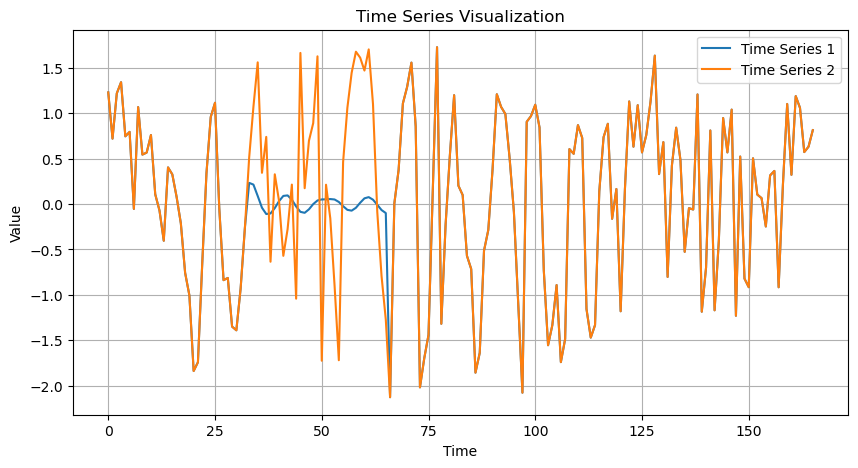

In [16]:
import numpy as np
import matplotlib.pyplot as plt

new1 = x_test_new1[2]
orig = x_test_original[2]

# 创建一个时间轴，对应于时间序列的索引
time_axis = np.arange(len(new1))

# 使用matplotlib绘制时间序列
plt.figure(figsize=(10, 5))  # 设置图形的大小
plt.plot(time_axis, new1, label='Time Series 1')  # 绘制第一个时间序列
plt.plot(time_axis, orig, label='Time Series 2')  # 绘制第二个时间序列

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Time Series Visualization')
plt.xlabel('Time')
plt.ylabel('Value')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

In [17]:
print(x_test_new1[2])

[[ 1.22773682e+00]
 [ 7.19025821e-01]
 [ 1.21697941e+00]
 [ 1.34006308e+00]
 [ 7.44597630e-01]
 [ 7.93563729e-01]
 [-5.41358541e-02]
 [ 1.06619636e+00]
 [ 5.43497087e-01]
 [ 5.65786973e-01]
 [ 7.58495243e-01]
 [ 1.07145772e-01]
 [-7.18903082e-02]
 [-4.04408609e-01]
 [ 4.02725908e-01]
 [ 3.25969564e-01]
 [ 8.00521835e-02]
 [-2.12900640e-01]
 [-7.56698452e-01]
 [-1.00503417e+00]
 [-1.83756749e+00]
 [-1.74116657e+00]
 [-6.65900940e-01]
 [ 3.38096385e-01]
 [ 9.57057663e-01]
 [ 1.11346685e+00]
 [-4.79182960e-02]
 [-8.37832310e-01]
 [-8.13769821e-01]
 [-1.34914693e+00]
 [-1.38955467e+00]
 [-9.29665608e-01]
 [-2.61786392e-01]
 [ 2.32247798e-01]
 [ 2.13289887e-01]
 [ 8.83190671e-02]
 [-4.12533208e-02]
 [-1.10259489e-01]
 [-1.04411613e-01]
 [-4.50873555e-02]
 [ 3.18535915e-02]
 [ 8.87120368e-02]
 [ 9.46651041e-02]
 [ 4.67625824e-02]
 [-2.76414876e-02]
 [-8.63106046e-02]
 [-9.70969623e-02]
 [-5.86491752e-02]
 [-1.20835853e-03]
 [ 3.86573971e-02]
 [ 5.03120258e-02]
 [ 5.11185052e-02]
 [ 5.4303641